# Word embedding

This notebook considers the possible use of [this](https://github.com/Ronshm/hebrew-word2vec) Wikipedia-based Hebrew word-embedding for analysis of the Israeli Knesset protocols.

Very brief analysis shows that while the embedded vocabulary looks comprehensive, using it properly requires a similar lemmatizer to the one used in the embedding.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords
from Parser import Parser, show_freqs, ordered_counter, EXTRA_STOPWORDS

In [4]:
mpl.rcParams.update({'font.size': 13})

## Load data

In [13]:
%%time
DATA = Path('Data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

Wall time: 35 s


In [19]:
# demo - only 1000 protocols
n = 1000
id_cut = int(meta.ID.values[n])
meta = meta[:n]
i_cut = next(i for i in range(len(df)) if df.ID.values[i]==id_cut)
df = df[:i_cut]
print(meta.shape)
print(df.shape)

(1000, 17)
(44795, 4)


In [20]:
%time p = Parser(df, meta)

100%|██████████████████████████████████████████████████████████████████████████| 44795/44795 [00:05<00:00, 7880.18it/s]


Vocabulary: 1000'th word => 141 occurences.
Vocabulary: 10 occurences => 11394 words.


1000it [00:05, 169.05it/s]


Wall time: 12.6 s


## Wiki-based embedding

In [21]:
SOURCE = Path('Data/Embeddings/wiki-w2v/')

In [30]:
with open(SOURCE/'words_list.txt','r',encoding='utf8') as f:
    words = f.read().split('\n')

In [44]:
print(f'Embedded words:\t{len(words):d}')
print(f'Unique embedded words:\t{len(np.unique(words)):d}')
print('A sample of words (meaningless single chars are true part of the sample):',*(words[:10]+words[-10:]),sep='\t')

Embedded words:	347223
Unique embedded words:	347223
A sample of words (meaningless single chars are true part of the sample):	</s>	ה	ב	,	.	ו	ל	של	ש	"	קקילי	דה-סימיאן	שטיינבארג	קופיפליירינג	האלקמיונידים	ואלקיביאדס	ארנהולם	קרג'יסקי	מקלות~הנקישה	


Is the vocabulary of our protocols' parser included in the vocabulary of the embedding?

In [45]:
is_included = [w in words for w in p.vocabulary]
included = [w for w in p.vocabulary if w in words]
excluded = [w for w in p.vocabulary if w not in words]

In [46]:
print("A sample of popular protocols' words included in embedding:",*(included[:10]+included[-10:]),sep='\t')
print("A sample of popular protocols' words excluded from embedding:",*(excluded[:10]+excluded[-10:]),sep='\t')

A sample of popular protocols' words included in embedding:	אחד	ישראל	שני	יום	מס'	1	מיליון	שנים	לתת	שעה	פעילות	נשאר	ומי	בשר	לקדם	תאונות	שטרן	מתייחס	זוכר	נוספות
A sample of popular protocols' words excluded from embedding:	האוצר	מישיבת	הישיבה	הכספים	הכלכלה	השר	הבעיה	ח''כ	החינוך	לחוק	הילדים	התשובה	ל-	השיכון	הסיכום	הרפורמה	הדוח	שאנו	וצריך	שרוצה


In [47]:
[w in words for w in ['כספים','כסף','ישיבה','כלכלה']]

[True, True, True, True]

So it seems that the embedding has valid vocabulary, but **only if we lemmatize our tokens similarly** (which we currently don't).
Otherwise we miss informative words in very popular forms.

Let's have a look at the embedded vectors as well:

In [48]:
w2v = np.load(SOURCE/'words_vectors.npy')

(347222, 100)


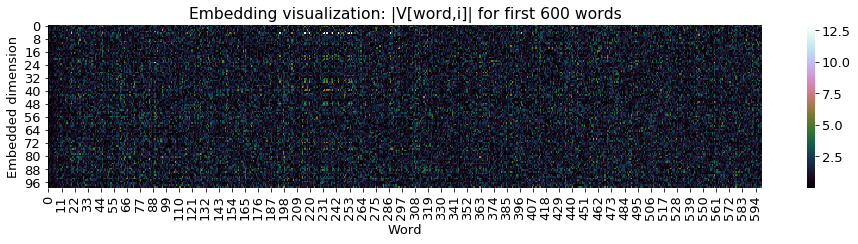

In [71]:
plt.figure(figsize=(16,3))
sns.heatmap(np.abs(w2v[:600,:]).transpose(), cmap='cubehelix')
plt.xlabel('Word')
plt.ylabel('Embedded dimension')
plt.title('Embedding visualization: |V[word,i]| for first 600 words')
print(w2v.shape)